In [1]:
import numpy as np
import torch
from pathlib import Path
from pyro.distributions import Normal
import os
from bnn_priors.models import DenseNet
from bnn_priors.inference import SGLD
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
data = np.load("../data/snelson.npz")

model = DenseNet(1,1,32)
if torch.cuda.is_available():
    model = model.cuda()

x_train = torch.from_numpy(data['x_train']).unsqueeze(1).to(model.lin1.weight)
y_train = torch.from_numpy(data['y_train']).unsqueeze(1).to(x_train)

x_test = torch.from_numpy(data['x_test']).unsqueeze(1).to(x_train)

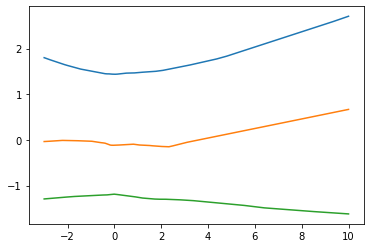

In [3]:
with torch.no_grad():
    for _ in range(3):
        model.sample_all_priors()
        y = model(x_test).loc.cpu()
        plt.plot(x_test.cpu(), y)

In [4]:
N_steps = 1000 # 100
warmup = 2000 # 50

model.sample_all_priors()
sgld = SGLD(model=model, num_samples=N_steps, warmup_steps=warmup, learning_rate=1e-4)
sgld.run(x=x_train, y=y_train)

samples = sgld.get_samples()

It. 0, loss=-934.9639
It. 100, loss=-1545.1354
It. 200, loss=-1549.3582
It. 300, loss=-1550.6483
It. 400, loss=-1551.5432
It. 500, loss=-1552.2814
It. 600, loss=-1552.9709
It. 700, loss=-1553.6345
It. 800, loss=-1554.2808
It. 900, loss=-1554.9124
It. 1000, loss=-1555.5310
It. 1100, loss=-1556.1373
It. 1200, loss=-1556.7327
It. 1300, loss=-1557.3159
It. 1400, loss=-1557.8889
It. 1500, loss=-1558.4507
It. 1600, loss=-1559.0021
It. 1700, loss=-1559.5435
It. 1800, loss=-1560.0747
It. 1900, loss=-1560.9221
It. 0, loss=-1561.7119
It. 100, loss=-1562.2141
It. 200, loss=-1562.7031
It. 300, loss=-1563.1807
It. 400, loss=-1563.6471
It. 500, loss=-1564.1038
It. 600, loss=-1564.5500
It. 700, loss=-1564.9872
It. 800, loss=-1565.4146
It. 900, loss=-1565.8331


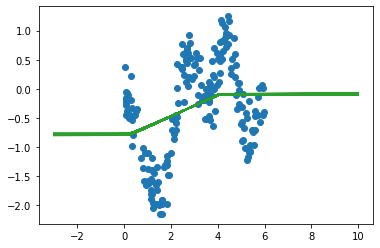

In [6]:
for i in range(N_steps):
    param_sample = {param : value[i] for param, value in samples.items()}
    model.load_state_dict(param_sample)
    with torch.no_grad():
        plt.plot(x_test.cpu(), model(x_test).loc.cpu(), color="C2", alpha=0.7)
plt.scatter(x_train.cpu(), y_train.cpu())
plt.show()